In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot, make_dot_from_trace
import pdb

In [16]:
class Pmul(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, g):
        ctx.save_for_backward(a,g)
        return torch.mul(a,g)

    @staticmethod
    def backward(ctx, grad_output):
        #pdb.set_trace()
        a,g = ctx.saved_tensors
        da = grad_output*g 
        dg = grad_output*a
        return da, dg


In [17]:
class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.a = nn.Parameter(torch.mul(torch.ones(1,N),.5))
        self.g = nn.Parameter(torch.tensor([[1.5]], requires_grad=True))       #torch.rand(1,N))
        self.aGrad_list = []
        self.gGrad_list = []
        self.pmul = Pmul.apply
        
    def forward(self, x, z):
        self.a.register_hook(lambda x: print(f'a grad = {x.data}'))
        self.g.register_hook(lambda x: print(f'g grad = {x.data}'))
        return (1-self.a)*x + self.pmul(self.a,self.g)*torch.tanh(x+z)

In [18]:
lky = Leaky_Tanh(1)
print(f'alpha={lky.a} \t gamma={lky.g}')

alpha=Parameter containing:
tensor([[0.5000]], requires_grad=True) 	 gamma=Parameter containing:
tensor([[1.5000]], requires_grad=True)


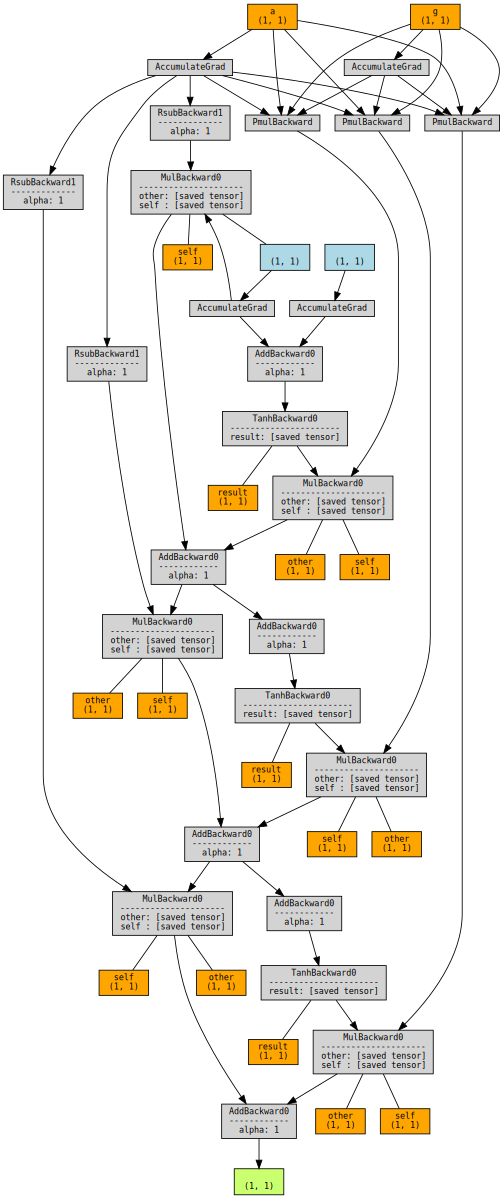

In [21]:
criterion = nn.MSELoss()
optimizer = optim.SGD(lky.parameters(),lr=.1)
x0 = torch.tensor([[2.]],requires_grad=True)
u0 = torch.tensor([[1.]],requires_grad=True)
u1 = torch.tensor([[3]])
u2 = torch.tensor([[5]])

x = lky(x0,u0)
x = lky(x,u1)
x = lky(x,u2)
#x.backward()
#optimizer.step()
make_dot(x, params=dict(lky.named_parameters()), show_attrs=True, show_saved=True)

In [6]:
-2+1.5*np.tanh(3)

-0.5074178694699043

In [7]:
.5*np.tanh(3)

0.49752737684336523

In [8]:
1-.5 + .5 * 1.5 * (1-np.tanh(3)**2)

0.5073995278740802

In [9]:
x0.grad

tensor([[0.5074]])

In [10]:
.5 * 1.5 * (1-np.tanh(3)**2)

0.0073995278740801584

In [11]:
u0.grad

tensor([[0.0074]])

In [ ]:
class SymESN(nn.Module):
    def __init__(self, k, n, l, r, rho):
        super(SymESN, self).__init__()

        self.N = n
        self.Q, self.d, self.Qt = self.initRes(r, rho)
        self.D = Parameter(self.d)
        self.Rin = nn.Linear(k, self.N, bias=False)
        self.Lky = Leaky_Tanh(self.N)
        self.Rout = nn.Linear(self.N+k,l, bias=False)
        self.sr_list = []

    def forward(self, hidden, ut):
        self.D.register_hook(lambda x: self.sr_list.append(x.data)) # Gradient
        z = self.Rin(ut)
        ht = torch.matmul(hidden,torch.matmul(self.Q, torch.matmul(torch.diag(self.D), self.Qt)))#self.Res(hidden)
        ht1 = self.Lky(ht,z)
        output = self.Rout(torch.cat((ht1,ut),1))
        return ht1, output

    def packState(self, h=None):
        if(not h):
            h = torch.randn(1, self.N)
        else:
            h = h.detach_()
        return h
    def initRes(self, r, rho):
        A = torch.mul(torch.sub(torch.rand((self.N,self.N)),.5),2.)
        W = (A + torch.transpose(A,0,1))-torch.diag(torch.diagonal(A))
        eigmax = torch.max(torch.abs(torch.linalg.eigvals(W)))
        Wszd = torch.mul(torch.div(W,eigmax),rho)
        D,Q = torch.linalg.eig(Wszd)
        return torch.real(Q), torch.real(D), torch.real(torch.transpose(Q,0,1))
    
    def clearList(self):
        self.Lky.aGrad_list = []
        self.Lky.gGrad_list = []
        self.sr_list = []


esn = SymESN(K,N,L,1.0,.6)
print(esn)
for n,p in esn.named_parameters():
    print(n)

In [ ]:
a = torch.ones(5)
a.requires_grad = True
b = 2*a
b.retain_grad()
b.register_hook(lambda x: 2*x)   # Changing grad graph through hook 
b.mean().backward()
print(a.grad,b.grad)

In [ ]:
a = torch.ones(5)
a.requires_grad = True
b = 2*a
b.retain_grad()
#b.register_hook(lambda x: 2*x)
b.mean().backward()                # Does not change graph... a.grad remains same
print(a.grad,b.grad)
b.grad *= 2.
print(a.grad,b.grad)

In [ ]:
a = torch.ones(1)*3
a.requires_grad = True

x = torch.ones(1)*4
x.requires_grad = True
z = torch.ones(1)*7
z.requires_grad = True
b = torch.ones(1)*2
b.requires_grad = True

c = (1-a)*x + a*b*torch.tanh(x + z)
c.backward()

In [ ]:
print(f'{a.grad}\n{b.grad}\n{x.grad}\n{z.grad}\n')

In [ ]:
x = torch.randn(5, requires_grad=True)
y = x.pow(2)
print(x.equal(y.grad_fn._saved_self))  # True
print(x is y.grad_fn._saved_self)  # True

In [ ]:
class MyReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        pdb.set_trace()
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input


In [ ]:
pmul = Pmul.apply
alpha = torch.tensor([[2.]], requires_grad=True)
gamma = torch.tensor([[11.]], requires_grad=True)

In [ ]:
c = pmul(alpha,gamma)
c.backward()

In [ ]:
alpha.grad

In [ ]:
gamma.grad